# **Tutorial Hysteresis and Ice Melt**

In this notebook, we will explore the implementation of the snow cover hysteresis and ice melt model.

The provided dataset, **hyst_ice_input.csv**, includes daily measurements from a catchment area. Covering a range of hydrological and climatic variables:

<span style="font-size: 85%">

| **Variable**              | **Source**                                                                                                                                                    |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Precipitation [mm]**     | [1] Hiebl, J.; Frei, C. (2018): *Daily precipitation grids for Austria since 1961—development and evaluation of a spatial dataset for hydroclimatic monitoring and modelling*. Theor Appl Climatol 132 (1-2), 327–345. DOI: [10.1007/s00704-017-2093-x](https://doi.org/10.1007/s00704-017-2093-x) |
| **Tmax [°C]**              | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **Tmin [°C]**              | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **Tmean [°C]**             | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **ET0 [mm]**               | [3] Haslinger, K.; Bartsch, A. (2016): *Creating long-term gridded fields of reference evapotranspiration in Alpine terrain based on a recalibrated Hargreaves method*. Hydrology and Earth System Sciences 20(3), 1211-1223. DOI: [10.5194/hess-20-1211-2016](https://doi.org/10.5194/hess-20-1211-2016) |
| **Qmm [mm]**               | [4] eHYD – *Austrian Hydrological Data Service*: [eHYD](https://ehyd.gv.at/#)                                                                                  |
| **Snow Cover Data** for 5 elevation bands      | [5] MODIS – *MODIS Snow Cover Data*: [NSIDC MODIS](https://nsidc.org/data/modis)                                                                              |

</span>

---

## **Modeling Tasks to Be Performed:**

The following tasks will be performed using the provided data:

1. **Cemaneige + Hysteresis + Icemelt + GR4J**
2. **Cemaneige + Hysteresis + GR4J**
3. **Cemaneige + Icemelt + GR4J**
4. **Visualization**



## **Input**

In [24]:
# Notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from rrmpg.models import CemaneigeHystGR4J, CemaneigeGR4JIce, CemaneigeHystGR4JIce
from rrmpg.utils.metrics import calc_kge

In [25]:
# fag_gep
df_in = pd.read_csv("hyst_ice_input.csv", index_col="Date", sep=";", decimal=".", parse_dates=["Date"])
df_in.index

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2009-12-23', '2009-12-24', '2009-12-25', '2009-12-26',
               '2009-12-27', '2009-12-28', '2009-12-29', '2009-12-30',
               '2009-12-31', '2010-01-01'],
              dtype='datetime64[ns]', name='Date', length=732, freq=None)

In [26]:
# define the elevations
elevation = [float(2277.84423828125), # Mean elevation band 1
            float(2641.563720703125), # Mean elevation band 2
            float(2845.09521484375), # Mean elevation band 3
            float(3002.329833984375), # Mean elevation band 4
            float(3227.36669921875)] # Mean elevation band 5

mean_elev = 2798.84033203125 # Mean elevation of the catchment

In [27]:
# Glacier fraction for each elevation layer
frac_ice = np.array([0.022034026, 0.042062109, 0.246620231, 0.507329678, 0.709368134])

In [28]:
# Generating a dataframe to store the simulated discharges
# Initialize columns with no data
df1 = pd.DataFrame({
    'Datum': df_in.index,  # Using the index of df_in for the 'Datum' column
    'Qmm': df_in['Qmm'],  # Column 'Qmm' from df_in
    'sim HystIce(mm/d)': np.nan, # Cemaneige + Hysteresis + Icemelt + GR4J
    'sim Hyst(mm/d)': np.nan, # Cemaneige + Hysteresis + GR4J
    'sim CemaneigeIce(mm/d)': np.nan}) # Cemaneige + Icemelt + GR4J

# Display the first few rows of df1
print(df1.head())

                Datum       Qmm  sim HystIce(mm/d)  sim Hyst(mm/d)  \
Date                                                                 
2008-01-01 2008-01-01  0.406550                NaN             NaN   
2008-01-02 2008-01-02  0.405108                NaN             NaN   
2008-01-03 2008-01-03  0.402225                NaN             NaN   
2008-01-04 2008-01-04  0.399341                NaN             NaN   
2008-01-05 2008-01-05  0.397900                NaN             NaN   

            sim CemaneigeIce(mm/d)  
Date                                
2008-01-01                     NaN  
2008-01-02                     NaN  
2008-01-03                     NaN  
2008-01-04                     NaN  
2008-01-05                     NaN  


## **Cemaneige + Hysteresis + Icemelt + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** + **Hysteresis** + **Icemelt Model** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using an **objective function** :

- **75% Discharge Data** (Qmm): Used to calibrate the model's hydrological performance.
- **25% Remote Sensing Snow Cover Data**: This is split across the 5 elevation bands, with 5% allocated per elevation band for snow cover calibration.

### **Loss Metric Options**

During the calibration process, users can select between two different loss metrics to evaluate model performance:

1. **Kling-Gupta Efficiency (KGE)**
   
2. **Mean Squared Error (MSE)**


In [29]:
# Define the model with initial parameters
model1 = CemaneigeHystGR4JIce()
params1= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'Thacc': 43, 'Rsp': 0.23, # Hysteresis parameters
          'x1': 210, 'x2': 3.4, # GR4J parameters
          'x3': 49, 'x4': 2.2, # GR4J parameters
          "DDF": 5} # Icemelt parameter
model1.set_params(params1) # Set the parameters

In [30]:
# NDSI from df_in into SCA (snow covered area) for each band
sca1modis = (0.06 + 1.21 * df_in["NDSI1"]).clip(upper=100)
sca2modis = (0.06 + 1.21 * df_in["NDSI2"]).clip(upper=100)
sca3modis = (0.06 + 1.21 * df_in["NDSI3"]).clip(upper=100)
sca4modis = (0.06 + 1.21 * df_in["NDSI4"]).clip(upper=100)
sca5modis = (0.06 + 1.21 * df_in["NDSI5"]).clip(upper=100)

In [31]:
# Fit the model
# Choose the loss metric: kge or mse
result = model1.fit_Q_SCA(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], frac_ice, sca1modis, sca2modis, sca3modis, sca4modis, sca5modis,
                    met_station_height=mean_elev, loss_metric="kge", # mse or kge 
                    altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.17769761809401766
                   x: [ 6.152e-01  1.661e+00  2.321e+01  3.372e-01
                        1.325e+01  2.934e+00  2.368e+01  1.322e+00
                        9.844e+00]
                 nit: 101
                nfev: 14440
          population: [[ 6.152e-01  1.661e+00 ...  1.322e+00  9.844e+00]
                       [ 5.312e-01  1.599e+00 ...  1.336e+00  1.028e+01]
                       ...
                       [ 6.221e-01  1.580e+00 ...  1.289e+00  1.001e+01]
                       [ 6.364e-01  1.714e+00 ...  1.205e+00  1.044e+01]]
 population_energies: [ 1.777e-01  1.821e-01 ...  1.784e-01  1.814e-01]


In [32]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model1.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model1.set_params(params)

# To be sure, let's look at the current model parameters
model1.get_params()

{'CTG': np.float64(0.6152121334073842),
 'Kf': np.float64(1.660534877001667),
 'Thacc': np.float64(23.213611744721334),
 'Rsp': np.float64(0.33719554761015796),
 'x1': np.float64(13.252855530545503),
 'x2': np.float64(2.9344639936814136),
 'x3': np.float64(23.68219964705395),
 'x4': np.float64(1.3219619858729992),
 'DDF': np.float64(9.843811415102476)}

In [33]:
# Simulate the discharge and sca, icemlet, snowmelt, rain
# Store the simulated discharge in the df1 dataframe
df1['sim HystIce(mm/d)'] = model1.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

## **Cemaneige + Hysteresis + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** with **Hysteresis** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using an **objective function** :

- **75% Discharge Data** (Qmm): Used to calibrate the model's hydrological performance.
- **25% Remote Sensing Snow Cover Data**: This is split across the 5 elevation bands, with 5% allocated per elevation band for snow cover calibration.

### **Loss Metric Options**

During the calibration process, users can select between two different loss metrics to evaluate model performance:

1. **Kling-Gupta Efficiency (KGE)**
   
2. **Mean Squared Error (MSE)**

In [34]:
# Define the model with initial parameters
model2 = CemaneigeHystGR4J()
params2= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'Thacc': 43, 'Rsp': 0.23,  # Hysteresis parameters
          'x1': 210, 'x2': 3.4,
          'x3': 49, 'x4': 2.2}  # GR4J parameters
model2.set_params(params2)

In [35]:
# NDSI from df_in into SCA
sca1modis = (0.06 + 1.21 * df_in["NDSI1"]).clip(upper=100)
sca2modis = (0.06 + 1.21 * df_in["NDSI2"]).clip(upper=100)
sca3modis = (0.06 + 1.21 * df_in["NDSI3"]).clip(upper=100)
sca4modis = (0.06 + 1.21 * df_in["NDSI4"]).clip(upper=100)
sca5modis = (0.06 + 1.21 * df_in["NDSI5"]).clip(upper=100)

In [36]:
result = model2.fit_Q_SCA(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], sca1modis, sca2modis, sca3modis, sca4modis, sca5modis, met_station_height=mean_elev, loss_metric="kge", # mse or kge 
                    altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.22954760672836577
                   x: [ 9.769e-01  4.979e+00  2.185e+01  3.435e-02
                        1.135e+01  2.998e+00  2.014e+01  1.197e+00]
                 nit: 91
                nfev: 12048
          population: [[ 9.769e-01  4.979e+00 ...  2.014e+01  1.197e+00]
                       [ 9.744e-01  4.487e+00 ...  2.013e+01  1.276e+00]
                       ...
                       [ 9.736e-01  4.311e+00 ...  2.018e+01  1.370e+00]
                       [ 9.738e-01  4.233e+00 ...  2.012e+01  1.297e+00]]
 population_energies: [ 2.295e-01  2.377e-01 ...  2.354e-01  2.350e-01]


In [37]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model2.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model2.set_params(params)

# To be sure, let's look at the current model parameters
model2.get_params()

{'CTG': np.float64(0.976858058306128),
 'Kf': np.float64(4.979384941016117),
 'Thacc': np.float64(21.854713976449204),
 'Rsp': np.float64(0.03434509368046684),
 'x1': np.float64(11.348959858282683),
 'x2': np.float64(2.997506678095875),
 'x3': np.float64(20.135465489614035),
 'x4': np.float64(1.1968762218757751)}

In [38]:
# Simulate the discharge and store it in the df1 dataframe
df1['sim Hyst(mm/d)'] = model2.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

## **Cemaneig + Icemelt + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** (**WITHOUT** Hysteresis) + **Icemelt Model** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using a **loss-function** only on discharge data. The available loss metric is **Mean Squared Error (MSE)**.

In [39]:
# Define the model with initial parameters
model3 = CemaneigeGR4JIce()
params3= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'x1': 210, 'x2': 3.4,
          'x3': 49, 'x4': 2.2, # GR4J parameters
          "DDF": 5}   # Icemelt parameter
model3.set_params(params3)

In [40]:
# Fit the model
result = model3.fit(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev,
                    altitudes=elevation, s_init=0.5, r_init=0.4)
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 6.1156260658590895
                   x: [ 7.641e-01  4.215e+00  1.362e+02  2.968e+00
                        2.466e+01  1.282e+00  7.059e+00]
                 nit: 39
                nfev: 5240
          population: [[ 7.641e-01  4.215e+00 ...  1.282e+00  7.059e+00]
                       [ 8.871e-01  4.311e+00 ...  1.296e+00  6.912e+00]
                       ...
                       [ 5.512e-01  4.075e+00 ...  1.314e+00  6.863e+00]
                       [ 7.450e-01  4.231e+00 ...  1.248e+00  7.298e+00]]
 population_energies: [ 6.116e+00  6.215e+00 ...  6.289e+00  6.183e+00]


In [41]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model3.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model3.set_params(params)

# To be sure, let's look at the current model parameters
model3.get_params()

{'CTG': np.float64(0.7640549622046547),
 'Kf': np.float64(4.215428943965481),
 'x1': np.float64(136.1691163107754),
 'x2': np.float64(2.968051337755946),
 'x3': np.float64(24.661833356371943),
 'x4': np.float64(1.282123559355053),
 'DDF': np.float64(7.0589694246908365)}

In [42]:
df1['sim CemaneigeIce(mm/d)'] = model3.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4)

## **Plot Model Runs**

In this section, we will visualize the results of all the different model runs and compare them to the observed data. The following steps will be performed:

1. **Plotting Model Runs**: All the different model runs will be plotted together for visual comparison with the observed data.

2. **Kling-Gupta Efficiency (KGE) Calculation**: The **KGE** will be calculated for each model run to assess the performance of the models in relation to the observed data.


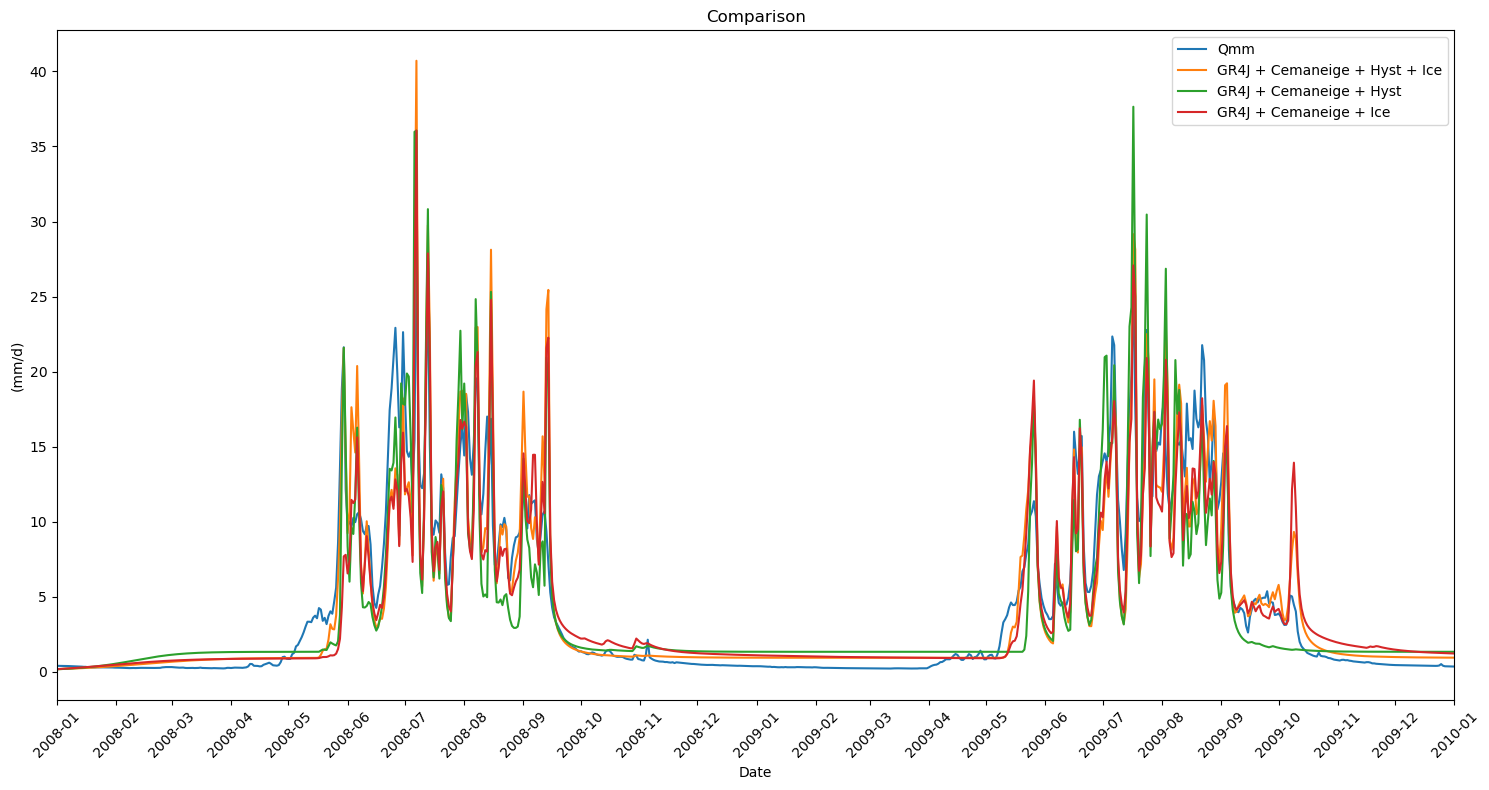

In [43]:
# Define the date range for slicing
s1, e1 = ("2008-01-01", "2010-01-01")

# Create figure
plt.figure(figsize=(15, 8))

# Plot the columns within the specified date range
df1.loc[s1:e1, "Qmm"].plot(label="Qmm")
df1.loc[s1:e1, "sim HystIce(mm/d)"].plot(label="GR4J + Cemaneige + Hyst + Ice")
df1.loc[s1:e1, "sim Hyst(mm/d)"].plot(label="GR4J + Cemaneige + Hyst")
df1.loc[s1:e1, "sim CemaneigeIce(mm/d)"].plot(label="GR4J + Cemaneige + Ice")

# Add legend, labels, and title 
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.ylabel("(mm/d)")
plt.title("Comparison")

# Display the plot
plt.tight_layout()
plt.show()


In [44]:
# Calculate the different KGE values
kge_hyst_ice = calc_kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim HystIce(mm/d)"])
kge_hyst = calc_kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim Hyst(mm/d)"])
kge_cemaneigeice = calc_kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim CemaneigeIce(mm/d)"])

# Print the results
print("KGE for GR4J + Cemaneige + Hyst + Ice:", kge_hyst_ice)
print("KGE for GR4J + Cemaneige + Hyst:", kge_hyst)
print("KGE for GR4J + Cemaneige + Ice:", kge_cemaneigeice)

KGE for GR4J + Cemaneige + Hyst + Ice: 0.9132657661167222
KGE for GR4J + Cemaneige + Hyst: 0.8764808959553352
KGE for GR4J + Cemaneige + Ice: 0.8541492237969747
